<a href="https://colab.research.google.com/github/wvirany/mini_projects/blob/main/deep_learning/zero_to_hero/building_makemore_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [298]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [299]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [300]:
len(words)

32033

In [301]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [302]:
# hyperparameters
block_size = 4 # context length: how many characters do we take to predict the next
embedding_size = 10 # dimension of embedding vector

In [303]:
# build the dataset

def build_dataset(words, block_size):

  X, Y = [], []

  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [304]:
import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, y_test = build_dataset(words[n2:], block_size)

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [305]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((block_size * embedding_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]

In [306]:
sum(p.nelement() for p in params) # total number of parameters

13897

In [307]:
for p in params:
  p.requires_grad = True

In [308]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [309]:
lri = []
losses = []
step = []

In [310]:
for i in range(20000):

  # minibatch construction
  ix = torch.randint(0, X_train.shape[0], (128,))

  # forward pass
  emb = C[X_train[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix])

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # track stats
  step.append(i)
  losses.append(loss.log10().item())

print(loss.item())

2.0474846363067627


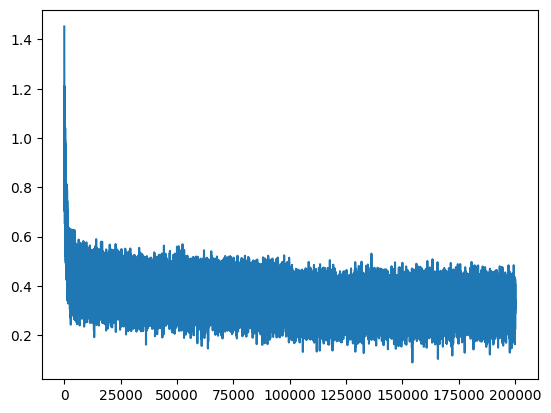

In [311]:
plt.plot(step, losses)

In [314]:
emb = C[X_val] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.1898, grad_fn=<NllLossBackward0>)

## Sampling from the model

In [316]:
g = torch.Generator().manual_seed(2147483647)
block_size = 4

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

junide.
jakakir.
presty.
adiya.
jimrleo.
sassaret.
kalania.
yani.
dayaj.
dedainr.
ibel.
seiyanay.
artellaveumerya.
demmerninas.
jahosani.
core.
yaez.
cary.
jamiya.
jamii.
